In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:05<00:00, 31.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
# Load pre-trained ResNet-18 model
import torchvision.models as models

model = models.resnet18(pretrained=True)

# Modify the final layer for CIFAR-10
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Train the model
def train(model, trainloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")


# Train the model
train(model, trainloader, criterion, optimizer, num_epochs=10)

# Evaluate the model
evaluate(model, testloader)

# Save the model
torch.save(model.state_dict(), "cifar_resnet18_pretrained.pth")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


Epoch [1/10], Loss: 1.0514
Epoch [2/10], Loss: 0.7198
Epoch [3/10], Loss: 0.6252
Epoch [4/10], Loss: 0.5671
Epoch [5/10], Loss: 0.5215
Epoch [6/10], Loss: 0.4916
Epoch [7/10], Loss: 0.4686
Epoch [8/10], Loss: 0.4442
Epoch [9/10], Loss: 0.4277
Epoch [10/10], Loss: 0.4106
Accuracy: 81.61%


In [3]:
# Function to create a random patch
def create_patch(patch_size=(3, 3)):
    patch = torch.randn(3, *patch_size, requires_grad=True, device=device)
    return patch

# Function to apply the patch to images
def place_patch(img, patch):
    batch_size, _, h, w = img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        x_offset = torch.randint(0, h - ph + 1, (1,)).item()
        y_offset = torch.randint(0, w - pw + 1, (1,)).item()
        img[i, :, x_offset:x_offset+ph, y_offset:y_offset+pw] = patch
    return img

# Training function for adversarial patch
def patch_training_step(model, patch, target_class=None, dataloader=None, optimizer=None, criterion=None):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        patched_images = place_patch(images, patch)
        outputs = model(patched_images)
        if target_class is not None:
            labels = torch.full((images.size(0),), target_class, dtype=torch.long, device=device)
        else:
            labels = torch.randint(0, 10, (images.size(0),), device=device)  # Random class for untargeted attack
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

# Function to train the adversarial patch
def train_adversarial_patch(model, patch, target_class=None, num_epochs=10):
    patch_optimizer = optim.Adam([patch], lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        loss = patch_training_step(model, patch, target_class, trainloader, patch_optimizer, criterion)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

# Function to evaluate the success rate of the adversarial patch
def evaluate_patch(model, patch, dataloader, target_class=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)
            if target_class is not None:
                correct += (predicted == target_class).sum().item()
            else:
                correct += (predicted != labels).sum().item()  # Evaluate untargeted attack
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Attack Success Rate: {accuracy:.2f}%")

# Function to visualize the patch
def visualize_patch(patch):
    patch = patch.detach().cpu().numpy()
    patch = np.clip((patch - patch.min()) / (patch.max() - patch.min()), 0, 1)

    plt.figure(figsize=(2, 2))
    plt.imshow(np.transpose(patch, (1, 2, 0)))  # [C, H, W] -> [H, W, C]
    plt.title("Adversarial Patch")
    plt.axis('off')
    plt.show()

# Function to visualize misclassified patched images
def visualize_misclassified_patched_images(model, patch, dataloader, classes, num_examples=5):
    model.eval()
    examples_shown = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        patched_images = place_patch(images.clone(), patch)
        with torch.no_grad():
            original_preds = model(images).argmax(dim=1)
            patched_preds = model(patched_images).argmax(dim=1)
        for i in range(images.size(0)):
            # Display only if the original prediction is correct and the patched prediction is incorrect
            if original_preds[i] == labels[i] and patched_preds[i] != labels[i]:
                # Normalize back to [0, 1] range for visualization
                original_image = (images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5
                patched_image = (patched_images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5

                # Plot images with a fixed size to match CIFAR-10
                fig, axes = plt.subplots(1, 2, figsize=(4, 4))
                axes[0].imshow(np.clip(original_image, 0, 1))
                axes[0].set_title(f"Original Image\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[original_preds[i].item()]}")
                axes[0].axis('off')

                axes[1].imshow(np.clip(patched_image, 0, 1))
                axes[1].set_title(f"Image with Adversarial Patch\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[patched_preds[i].item()]}")
                axes[1].axis('off')

                plt.show()
                examples_shown += 1
                if examples_shown >= num_examples:
                    return


Training for patch size: (3, 3)
Epoch 1/20, Loss: 7.0183
Epoch 2/20, Loss: 6.8925
Epoch 3/20, Loss: 6.7832
Epoch 4/20, Loss: 6.7165
Epoch 5/20, Loss: 6.7096
Epoch 6/20, Loss: 6.6421
Epoch 7/20, Loss: 6.6168
Epoch 8/20, Loss: 6.6000
Epoch 9/20, Loss: 6.5720
Epoch 10/20, Loss: 6.5322
Epoch 11/20, Loss: 6.5653
Epoch 12/20, Loss: 6.5356
Epoch 13/20, Loss: 6.5037
Epoch 14/20, Loss: 6.5619
Epoch 15/20, Loss: 6.5759
Epoch 16/20, Loss: 6.5839
Epoch 17/20, Loss: 6.5381
Epoch 18/20, Loss: 6.5052
Epoch 19/20, Loss: 6.4698
Epoch 20/20, Loss: 6.4870
Visualizing patch of size (3, 3)


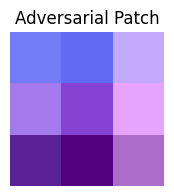

Attack Success Rate: 50.30%


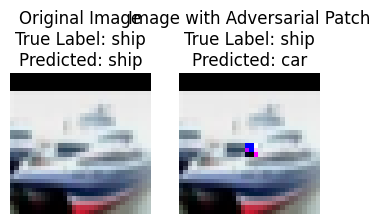

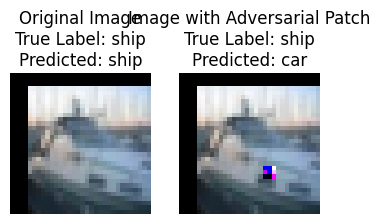

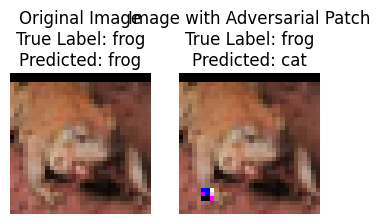

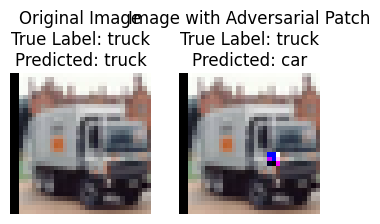

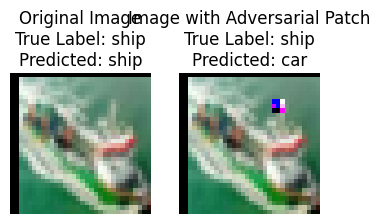


Training for patch size: (5, 5)
Epoch 1/20, Loss: 6.8912
Epoch 2/20, Loss: 6.7718
Epoch 3/20, Loss: 6.6342
Epoch 4/20, Loss: 6.6193
Epoch 5/20, Loss: 6.5315
Epoch 6/20, Loss: 6.5184
Epoch 7/20, Loss: 6.5173
Epoch 8/20, Loss: 6.5380
Epoch 9/20, Loss: 6.4300
Epoch 10/20, Loss: 6.4220
Epoch 11/20, Loss: 6.4423
Epoch 12/20, Loss: 6.4159
Epoch 13/20, Loss: 6.3736
Epoch 14/20, Loss: 6.4030
Epoch 15/20, Loss: 6.4598
Epoch 16/20, Loss: 6.3922
Epoch 17/20, Loss: 6.4234
Epoch 18/20, Loss: 6.4378
Epoch 19/20, Loss: 6.4426
Epoch 20/20, Loss: 6.4348
Visualizing patch of size (5, 5)


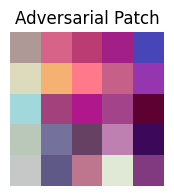

Attack Success Rate: 52.88%


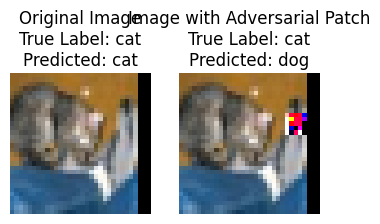

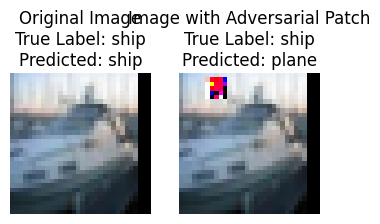

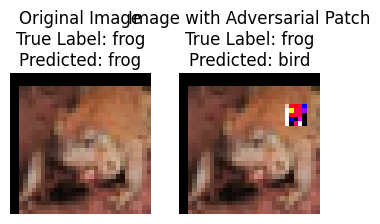

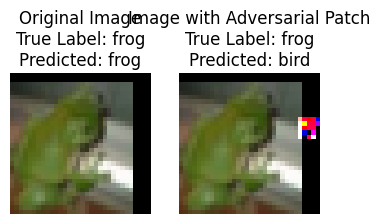

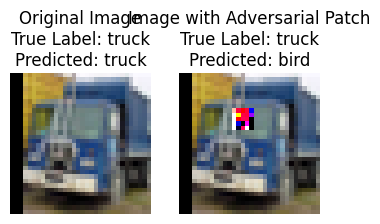


Training for patch size: (7, 7)
Epoch 1/20, Loss: 6.8544
Epoch 2/20, Loss: 6.7311
Epoch 3/20, Loss: 6.6411
Epoch 4/20, Loss: 6.5684
Epoch 5/20, Loss: 6.5736
Epoch 6/20, Loss: 6.5262
Epoch 7/20, Loss: 6.5332
Epoch 8/20, Loss: 6.5510
Epoch 9/20, Loss: 6.5047
Epoch 10/20, Loss: 6.4837
Epoch 11/20, Loss: 6.4800
Epoch 12/20, Loss: 6.4404
Epoch 13/20, Loss: 6.3593
Epoch 14/20, Loss: 6.4073
Epoch 15/20, Loss: 6.4062
Epoch 16/20, Loss: 6.3508
Epoch 17/20, Loss: 6.3241
Epoch 18/20, Loss: 6.3393
Epoch 19/20, Loss: 6.3456
Epoch 20/20, Loss: 6.3603
Visualizing patch of size (7, 7)


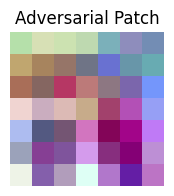

Attack Success Rate: 55.66%


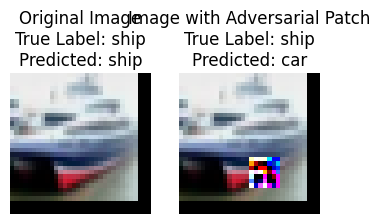

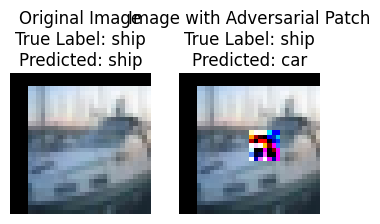

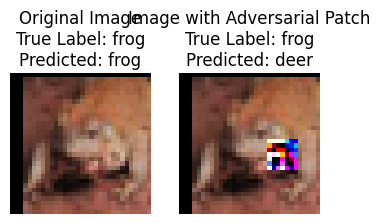

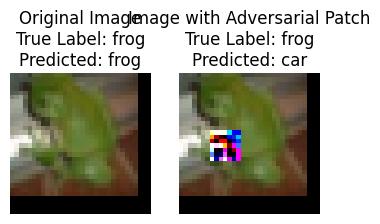

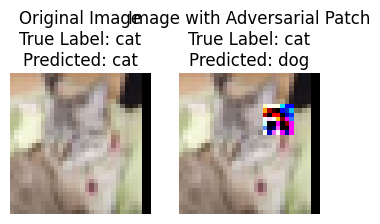


Training for patch size: (16, 16)
Epoch 1/20, Loss: 6.8436
Epoch 2/20, Loss: 6.3933
Epoch 3/20, Loss: 6.2967
Epoch 4/20, Loss: 6.2074
Epoch 5/20, Loss: 6.1436
Epoch 6/20, Loss: 6.0412
Epoch 7/20, Loss: 6.0088
Epoch 8/20, Loss: 5.8866
Epoch 9/20, Loss: 5.8436
Epoch 10/20, Loss: 5.7892
Epoch 11/20, Loss: 5.7091
Epoch 12/20, Loss: 5.7021
Epoch 13/20, Loss: 5.6224
Epoch 14/20, Loss: 5.6068
Epoch 15/20, Loss: 5.5612
Epoch 16/20, Loss: 5.5088
Epoch 17/20, Loss: 5.5174
Epoch 18/20, Loss: 5.4432
Epoch 19/20, Loss: 5.3993
Epoch 20/20, Loss: 5.3755
Visualizing patch of size (16, 16)


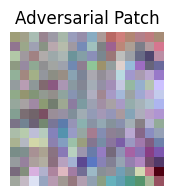

Attack Success Rate: 77.38%


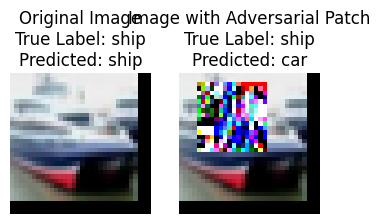

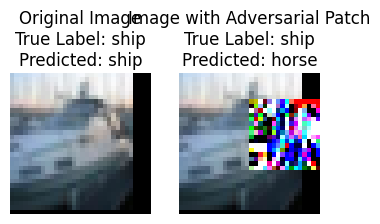

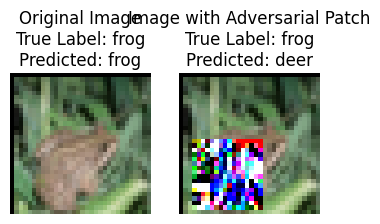

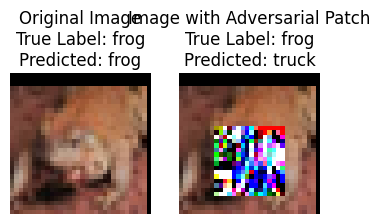

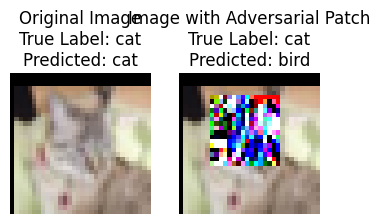

In [5]:
# CIFAR-10 class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Different patch sizes
patch_sizes = [(3, 3), (5, 5), (7, 7), (16, 16)]

# Train and evaluate patches of different sizes
for patch_size in patch_sizes:
    print(f"\nTraining for patch size: {patch_size}")
    patch = create_patch(patch_size)
    train_adversarial_patch(model, patch, target_class=None, num_epochs=20)

    # Save the patch
    torch.save(patch, f'adversarial_patch_{patch_size[0]}x{patch_size[1]}.pth')

    # Visualize the patch
    print(f"Visualizing patch of size {patch_size}")
    visualize_patch(patch)

    # Evaluate attack success rate
    evaluate_patch(model, patch, testloader)

    # Visualize misclassified examples with the adversarial patch
    visualize_misclassified_patched_images(model, patch, testloader, classes, num_examples=5)